In [1]:
import sys
from pathlib import Path

IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules
if IS_KAGGLE:
    repo_path = Path("../input/microstructure-reconstruction")
elif IS_COLAB:
    from google.colab import drive

    drive.mount("/content/gdrive")
    repo_path = Path("/content/gdrive/MyDrive/microstructure-reconstruction")
else:
    repo_path = Path("/home/matias/microstructure-reconstruction")
sys.path.append(str(repo_path))

import re
from copy import deepcopy
from importlib import reload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import torchvision.models as pretrained_models
import wandb
from custom_datasets import dataset
from custom_models import models
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler
from tools import dataframe_reformat, inspect_code, plotting, training, wandb_api
from torch.utils.data import DataLoader
from torchvision import transforms, utils
from tqdm import tqdm

wandb_api.login()
api = wandb.Api()
run_name = "3m9z3dh3"
run = api.run(f"matiasetcheverry/microstructure-reconstruction/{run_name}")
config = run.config

use_cuda = torch.cuda.is_available()
config["device"] = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 2, "pin_memory": True} if use_cuda else {"num_workers": 4}
print(f"[INFO]: Computation device: {config['device']}")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matiasetcheverry (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/matias/.netrc


[INFO]: Computation device: cpu


In [2]:
config

{'seed': 42,
 'device': device(type='cpu'),
 'epochs': 340,
 'job_type': 'train',
 'momentum': 0.9,
 'log_wandb': True,
 'loss_type': 'torch.nn.modules.loss.L1Loss',
 'batch_size': 64,
 'frac_noise': 0,
 'model_type': '__main__.PreTrainedVGG',
 'frac_sample': 1,
 'input_width': 64,
 'architecture': 'pretrained VGG',
 'fixed_layers': 0,
 'total_layers': 44,
 'weight_decay': 5e-05,
 'learning_rate': 0.0001,
 'optimizer_type': 'torch.optim.adam.Adam',
 'train_val_split': 0.7,
 'nb_image_per_axis': 5}

In [3]:
run = api.run(f"matiasetcheverry/microstructure-reconstruction/{run_name}")
root_path = Path("tmp/")

model_script = run.file("model_script.txt")
model_script = model_script.download(root=root_path / run.name, replace=True)
model_script.seek(0)

datamodule_script = run.file("datamodule_script.txt")
datamodule_script = datamodule_script.download(root=root_path / run.name, replace=True)
datamodule_script.seek(0)

checkpoint = run.file("epoch=326-val_loss=0.045.ckpt")
checkpoint.download(root=root_path / run.name, replace=True)

model_name = re.findall(r"(?<=class ).[a-zA-Z0-9_.-]*", model_script.read())[0]
model_script.seek(0)
datamodule_name = re.findall(r"(?<=class ).[a-zA-Z0-9_.-]*", datamodule_script.read())[
    0
]
datamodule_script.seek(0)
with open(model_script.name, "r") as file:
    exec(file.read())
with open(datamodule_script.name, "r") as file:
    exec(file.read())


In [4]:
dm = eval(datamodule_name)(config=config, repo_path=repo_path)
model = eval(model_name).load_from_checkpoint(
    root_path / run.name / checkpoint.name, config=run.config
)
trainer = pl.Trainer(devices="auto", accelerator="auto")
predictions = torch.cat(trainer.predict(model, datamodule=dm))
targets = torch.cat([label for _, label in dm.val_dataloader()])
dm.train_df

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Predicting: 0it [00:00, ?it/s]

,id,orientation-0_mean,orientation-1_mean,orientation-2_mean,orientation-3_mean,orientation-4_mean,orientation-5_mean,orientation-0_std,orientation-1_std,orientation-2_std,...,aspectratio-0_std,aspectratio-1_std,size_mean,size_std,solidity_mean,solidity_std,roundness_mean,roundness_std,volume_fraction,photos
0,Spec-197,0.356348,0.323515,0.320137,-0.017216,0.003262,-0.001308,0.314627,0.306735,0.304501,...,0.143148,0.102656,10.741075,2.938481,0.873860,0.055687,0.212789,0.087993,0.217926,[/home/matias/microstructure-reconstruction/RE...
1,Spec-344,0.347647,0.331023,0.321330,0.003530,0.002675,0.000964,0.322281,0.311201,0.305359,...,0.138008,0.124940,10.935470,2.712020,0.954486,0.083377,0.358212,0.143051,0.338746,[/home/matias/microstructure-reconstruction/RE...
2,Spec-99,0.359718,0.331703,0.308579,-0.012734,0.000141,0.003148,0.313214,0.306073,0.296053,...,0.139168,0.100356,10.947315,2.989302,0.870407,0.058849,0.212515,0.086692,0.223764,[/home/matias/microstructure-reconstruction/RE...
3,Spec-530,0.374891,0.358770,0.266340,0.239456,0.009192,0.008185,0.282298,0.283344,0.167377,...,0.133047,0.120841,11.482441,2.195267,0.928704,0.077101,0.292550,0.127101,0.141834,[/home/matias/microstructure-reconstruction/RE...
4,Spec-492,0.143142,0.139783,0.717074,0.247139,0.011478,0.001049,0.144587,0.143042,0.168408,...,0.136951,0.113757,10.953518,2.482555,0.919975,0.090867,0.277326,0.125126,0.296957,[/home/matias/microstructure-reconstruction/RE...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,Spec-163,0.310736,0.349786,0.339478,-0.005327,-0.000082,0.003391,0.297220,0.305787,0.309034,...,0.138733,0.105004,10.398206,2.797734,0.877064,0.054819,0.217739,0.089788,0.216830,[/home/matias/microstructure-reconstruction/RE...
416,Spec-195,0.335551,0.339138,0.325312,-0.001358,0.011718,-0.014050,0.309818,0.312565,0.307158,...,0.143635,0.102686,13.459184,4.464352,0.847222,0.103073,0.206318,0.086632,0.385221,[/home/matias/microstructure-reconstruction/RE...
417,Spec-342,0.334104,0.331458,0.334438,0.000891,0.002602,0.011794,0.313064,0.313294,0.313087,...,0.141975,0.124556,10.969777,2.483673,0.956011,0.078309,0.353728,0.148757,0.308272,[/home/matias/microstructure-reconstruction/RE...
418,Spec-491,0.144886,0.140017,0.715096,0.251179,-0.011591,-0.003892,0.153152,0.142701,0.171072,...,0.138290,0.117119,11.570258,2.803110,0.920576,0.084933,0.278994,0.129881,0.174805,[/home/matias/microstructure-reconstruction/RE...


In [5]:
def print_metric(predictions, targets):
    predictions = torch.FloatTensor(predictions)
    targets = torch.FloatTensor(targets)
    print(
        f"COSINE SIMILARITY: {torchmetrics.CosineSimilarity(reduction='mean')(predictions, targets)}"
    )
    print(f"R2 SCORE: {torchmetrics.R2Score(num_outputs=predictions.shape[1])(predictions, targets)}")
    print(
        f"SMAPE: {torchmetrics.SymmetricMeanAbsolutePercentageError()(predictions, targets)}"
    )
    print(f"MAPE: {torchmetrics.MeanAbsolutePercentageError()(predictions, targets)}")
    print(f"MAE: {torchmetrics.MeanAbsoluteError()(predictions, targets)}")
    print(f"MSE: {torchmetrics.MeanSquaredError()(predictions, targets)}")
    print(f"LOSS: {nn.L1Loss()(predictions, targets)}")
    print("_______________________________________________________________")

print("VALIDATION ON 'XYZ' ORDER ON NORMALIZED FABRICS")
print_metric(
    predictions, targets
)
print("VALIDATION ON 'XYZ' ORDER ON UNNORMALIZED FABRICS")
print_metric(
    dm.scaler.inverse_transform(predictions), dm.scaler.inverse_transform(targets)
)



VALIDATION ON 'XYZ' ORDER ON NORMALIZED FABRICS
COSINE SIMILARITY: 0.9938117861747742
R2 SCORE: 0.8225063681602478
SMAPE: 0.14541380107402802
MAPE: 183.1498260498047
MAE: 0.043985337018966675
MSE: 0.004581117536872625
LOSS: 0.043985337018966675
_______________________________________________________________
VALIDATION ON 'XYZ' ORDER ON UNNORMALIZED FABRICS
COSINE SIMILARITY: 0.9999046921730042
R2 SCORE: 0.8225167393684387
SMAPE: 0.21629038453102112
MAPE: 0.7766480445861816
MAE: 0.022022917866706848
MSE: 0.0055841244757175446
LOSS: 0.022022917866706848
_______________________________________________________________


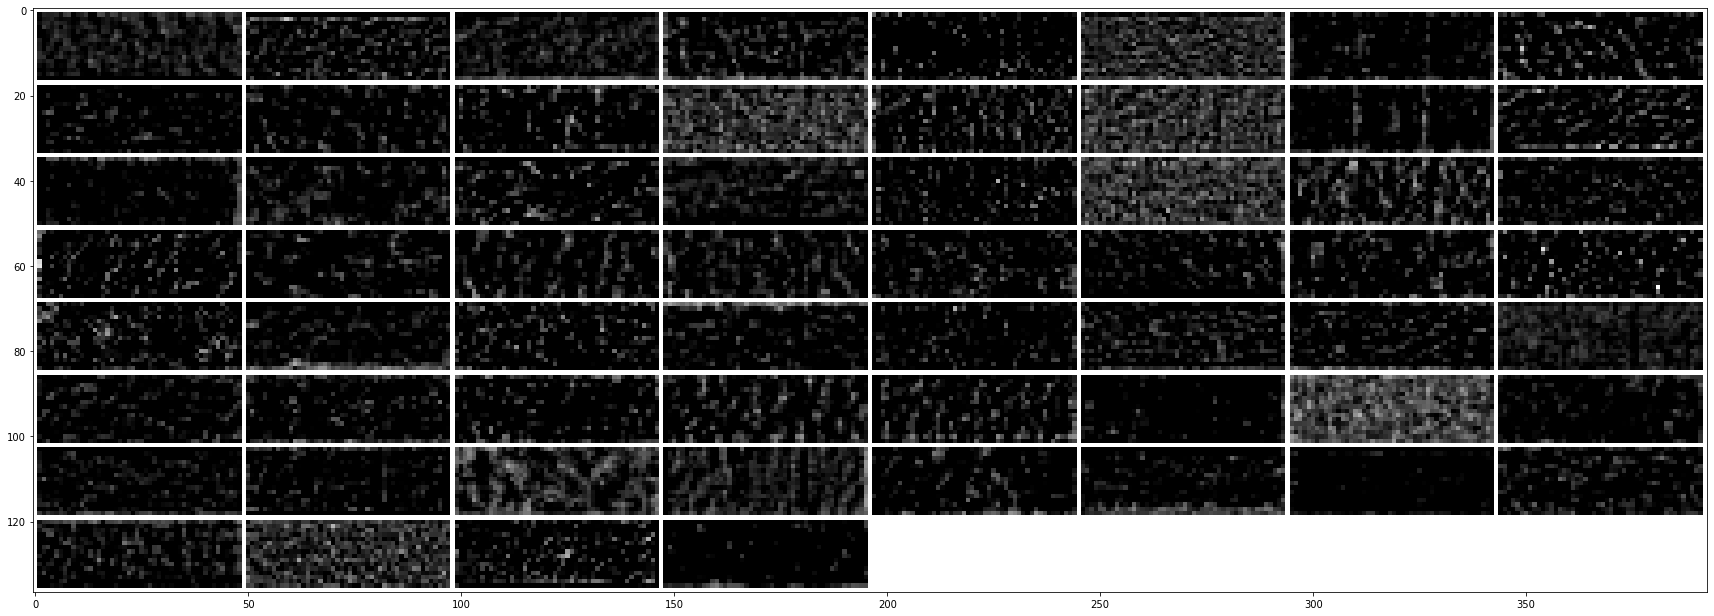

In [8]:
save_output = training.SaveOutput()
handle = model.layers[15].register_forward_hook(save_output)
images, labels = next(iter(dm.val_dataloader()))
image = images[0]
model(image.unsqueeze(0))
handle.remove()
outputs = save_output.outputs[0].permute(1, 0, 2, 3).detach().cpu()[:60]
grid_img = utils.make_grid(outputs, normalize=True, pad_value=1, padding=1)
plt.figure(figsize=(30, 30))
plt.imshow(grid_img.permute(1, 2, 0))


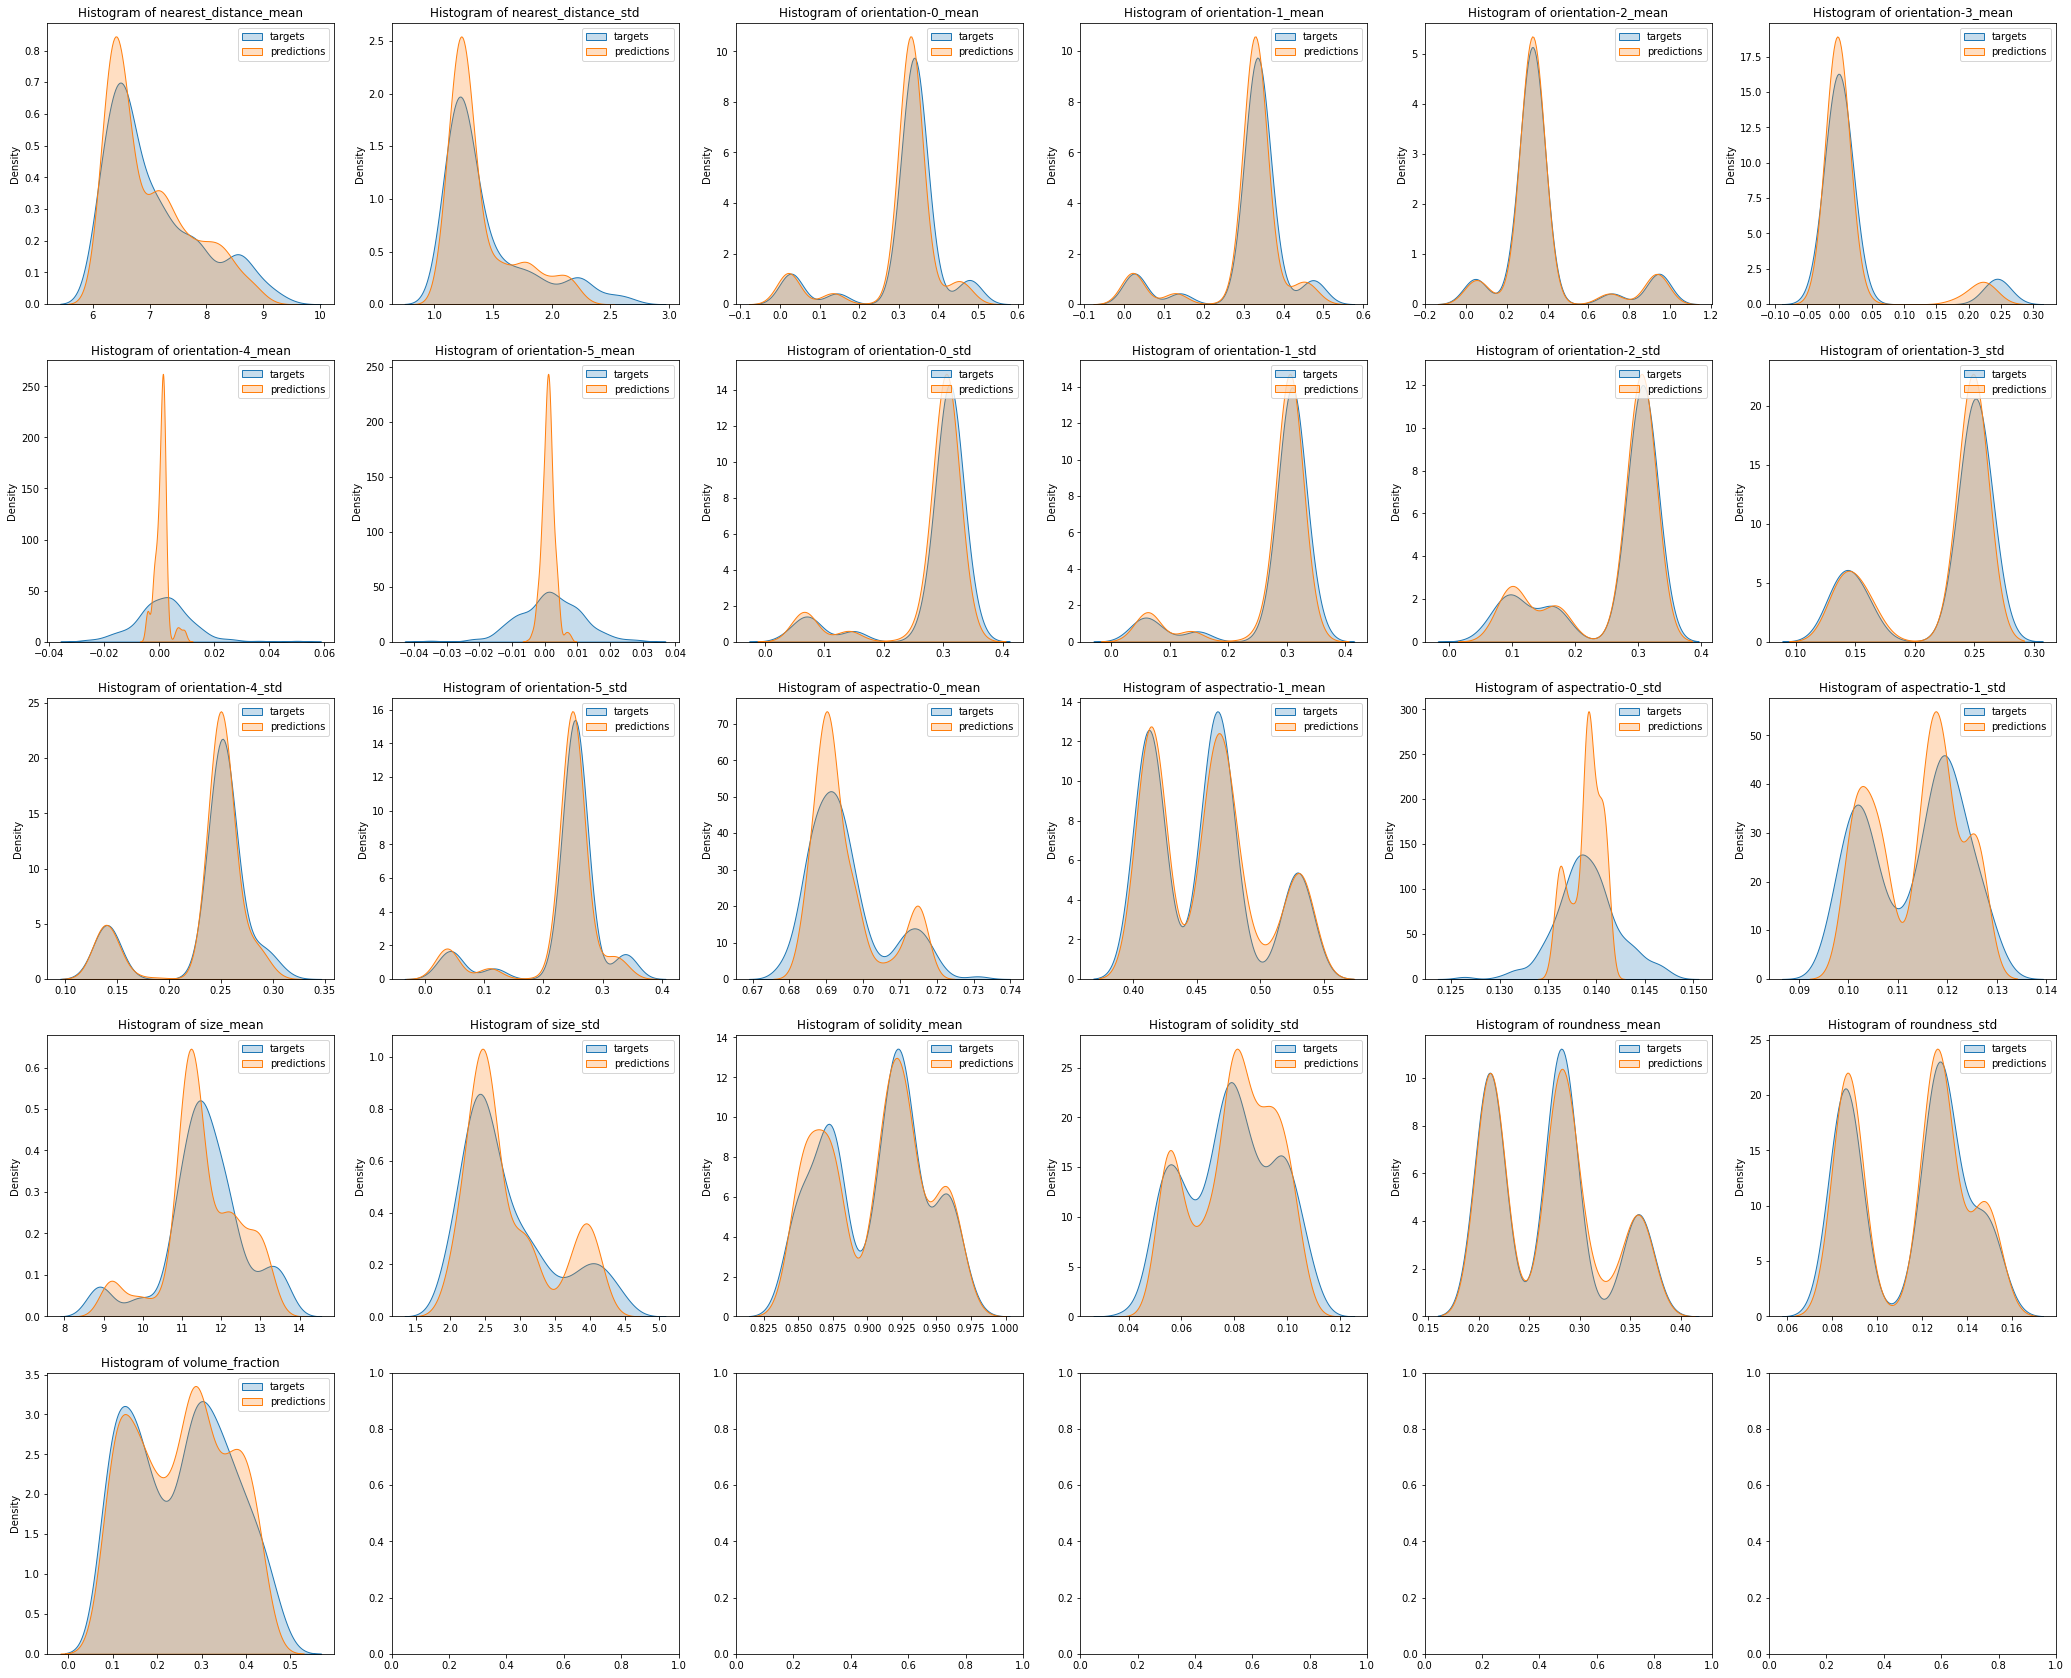

In [9]:
reload(plotting)
fig = plotting.plot_kde(
    [
        dm.scaler.inverse_transform(targets.cpu().numpy()),
        dm.scaler.inverse_transform(predictions.cpu().numpy()),
    ],
    nb_hist_per_line=6,
    columns=dm.train_df.columns[1:-1],
    labels=["targets", "predictions"],
)


In [25]:
def compute_mae_per_descriptor(targets, predictions):
    return torch.mean(torch.abs(targets - predictions), axis=0).cpu().numpy()


def compute_average_correlation(df):
    corr_matrix = df.corr().to_numpy()
    return np.array(
        [
            np.mean(np.abs(np.delete(corr_matrix[i, :], i)))
            for i in range(len(corr_matrix))
        ]
    )


train_df = dm.train_df.drop(labels="id", axis=1)
mae_per_descriptor = compute_mae_per_descriptor(targets, predictions)
average_correlation = compute_average_correlation(train_df)

sorted_idx_mae = np.argsort(mae_per_descriptor)
print(f"Largest MAE on:\n\t{np.array(train_df.columns)[sorted_idx_mae][:4]}")

sorted_idx_corr = np.argsort(average_correlation)
print(f"Lowest correlation on:\n\t{np.array(train_df.columns)[sorted_idx_corr][:4]}")

idx_lowest_corr = np.argmin(average_correlation)
print(
    f"Average correlation of {np.array(train_df.columns)[idx_lowest_corr]}: {average_correlation[idx_lowest_corr]}"
)
print(
    f"Average correlation elsewhere {np.mean(np.delete(average_correlation, sorted_idx_corr[:-1]))}"
)


Largest MAE on:
	['orientation-1_mean' 'orientation-5_std' 'orientation-0_std'
 'orientation-3_std']
Lowest correlation on:
	['orientation-2_std' 'orientation-2_mean' 'orientation-5_mean' 'size_mean']
Average correlation of orientation-2_std: 0.04639711602938918
Average correlation elsewhere 0.37591321222261387


<AxesSubplot:>

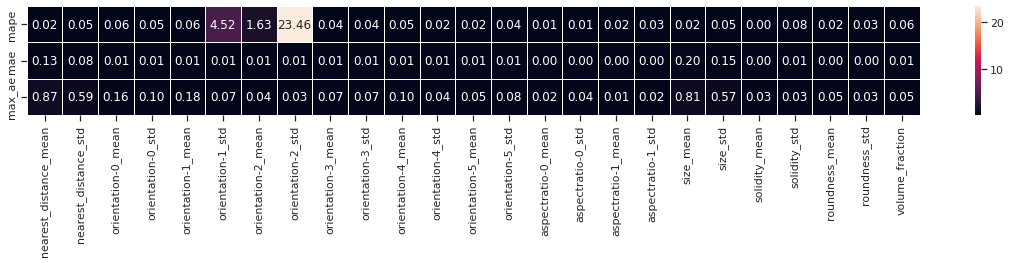

In [30]:
p = torch.Tensor(dm.scaler.inverse_transform(predictions))
t = torch.Tensor(dm.scaler.inverse_transform(targets))
mae = torch.mean(torch.abs(p - t), axis=0)
mape = torch.mean(torch.abs((p - t) / t), axis=0)
max_ae = torch.max(torch.abs(p - t), axis=0).values

data = pd.DataFrame.from_dict(
    {"mape": mape, "mae": mae, "max_ae": max_ae},
    columns=dm.train_df.columns[1:-1],
    dtype=float,
    orient="index",
)

fig = plt.figure(figsize=(20, 2))
sns.heatmap(
    data,
    annot=True,
    linewidths=0.5,
    fmt=".2f",
)


<Figure size 7200x7200 with 0 Axes>

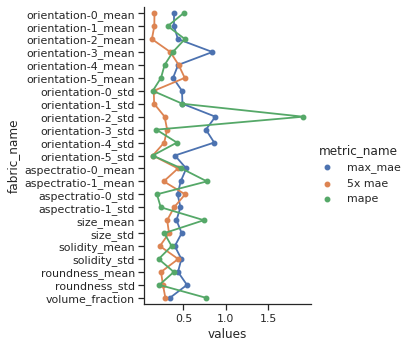

In [9]:
mae_df = pd.DataFrame(5 * mae, columns=["values"])
mae_df["metric_name"] = "5x mae"
mae_df["fabric_name"] = dm.train_df.columns[1:-1]
mape_df = pd.DataFrame(mape, columns=["values"])
mape_df["metric_name"] = "mape"
mape_df["fabric_name"] = dm.train_df.columns[1:-1]
max_ae_df = pd.DataFrame(max_ae, columns=["values"])
max_ae_df["metric_name"] = "max_mae"
max_ae_df["fabric_name"] = dm.train_df.columns[1:-1]

data = pd.concat([max_ae_df, mae_df, mape_df])
fig = plt.figure(figsize=(100, 100))
sns.set(style="ticks", rc={"lines.linewidth": 1})
sns.catplot(data=data, y="fabric_name", x="values", hue="metric_name", kind="point")
